In [13]:
%matplotlib inline
import math
import sys, os
import matplotlib.pyplot as plt
import spiceypy as spice 
from skimage import data, color, io
import skimage.draw as draw
import osgeo.gdal as gdal
import osgeo.gdal_array as gdal_array 
gdal.UseExceptions()
import pandas as pd
import pvl

In [14]:
class JunoCam:
    cx = 814.21
    cy = [315.48, 158.48, 3.48, -151.52]
    k1 = -5.9624209455667325e-08
    k2 = 2.7381910042256151e-14
    fl = 1480.5907441315994
    kerns_loaded = False
    
    #def __init__
    
    def undistort(self,c):
        """Project pixels from the FPA through the JunoCam optics"""
        xd, yd = c[0], c[1]
        for i in range(5):
            r2 = (xd**2+yd**2)
            dr = 1+self.k1*r2+self.k2*r2*r2
            xd = c[0]/dr
            yd = c[1]/dr
        return [xd, yd]

    
    def distort(self,c):
        """Project surface points into through the JunoCam optics to the FPA"""
        xd, yd = c[0], c[1]
        r2 = (xd**2+yd**2)
        dr = 1+self.k1*r2+self.k2*r2**2
        xd *= dr
        yd *= dr
        return [xd, yd]

    
    def vector2xy(self, v, band):
        """Find the pixel location based on a light ray from the target"""
        alpha = v[2]/self.fl
        cam = [v[0]/alpha, v[1]/alpha]
        cam = self.distort(cam)
        x = cam[0]+self.cx
        y = cam[1]+self.cy[band]
        return (x, y)

    
    def xy2vector(self,x, y, band):
        """Project a pixel to a look vector"""
        cam = [x-self.cx, y-self.cy[band]]
        cam = self.undistort(cam)
        v = (cam[0], cam[1], self.fl)
        return v

    def getkerns(self, path):
        kerns_loaded = True
        """Load the SPICE kernels."""
        spice.furnsh(path+"naif0012.tls")
        spice.furnsh(path+"pck00010.tpc")
        spice.furnsh(path+"juno_rec_170106_170228_170307.bsp")
        spice.furnsh(path+"juno_sc_rec_170205_170211_v01.bc")
        spice.furnsh(path+"juno_v12.tf")
        spice.furnsh(path+"jup310.bsp")
        spice.furnsh(path+"JNO_SCLKSCET.00072.tsc")
        
    def mark(self,x, y, color):
        """Mark a pixel. Usually used for finding a pixel that overlaps the target."""
        rr, cc = draw.circle(x, y, radius=1)
        self.im[cc,rr] = 255

    def scan(t, f_offset, band, color):
        """scan over the framelet with the given offsets and mark all pixels that hit the planet"""
        for y in range(0, 128, 4):
            for x in range(0, 1600, 4):
                # construct the vector in juno_junocam space...
                v = self.xy2vector(x, y, band)
                # and see if it intersects the target.
                vx = spice.sincpt("Ellipsoid", "jupiter", t, \
                                  "iau_jupiter", "lt+s", "juno", "juno_junocam", v)
                if vx:
                    self.mark(x, y+f_offset, color)

       
    def planet(self,t, f_offset, band, color):
        """plot the planet's nominal limb"""
        to_targ = spice.spkezr(self.targ, t, "iau_jupiter", "LT+S", "juno")[0][0:3]
        e = spice.edlimb(self.radii[0], self.radii[1], self.radii[2], spice.vminus(to_targ))
        c = spice.pxform("iau_jupiter", "juno_junocam", t)
        org = spice.vadd(e.center, to_targ)
        for th in range(-1800, 1800):
            p = spice.vadd(org, spice.vadd(spice.vscl(math.cos(math.radians(th/10.0)), e.semi_major), \
                                     spice.vscl(math.sin(math.radians(th/10.0)), e.semi_minor)))
            x, y = self.vector2xy(spice.mxv(c, p), band)
            if x >= 0 and x < 1648 and y >= 0 and y < 128:
                self.mark(x, y+f_offset, color)
  
    def find(self,f_offset, band, color):
        for dt in range(0, self.nframes, 1):
            t = self.t0+dt*(self.interframe)
            #scan(t, f_offset+128*3*dt, band, color)
            self.planet(t, f_offset+128*3*dt, band, color)

    
    def readimage(self, input_file):
        """Read in the PDS image"""
        imageds = gdal.Open(input_file, gdal.GA_ReadOnly)
        self.metadata =pvl.load(input_file)
        #print(metadata)
        self.start_time = self.metadata["SPACECRAFT_CLOCK_START_COUNT"]
        self.interframe = self.metadata["INTERFRAME_DELAY"].value + 1e-3
        imrb = imageds.GetRasterBand(1)
        self.im = imrb.ReadAsArray()
        self.nframes = int(self.im.size/384/1648)
        self.t0 = spice.scs2e(-61, self.start_time)+4094/50e3-20e-3 # metadata start time is 61.88 milliseconds early
        self.targ = "jupiter"
        self.radii = spice.bodvrd(self.targ, "RADII", 3)[1]
        
    def drawimage(self):
        fig, ax = plt.subplots(figsize=(40,40))
        image = color.gray2rgb(self.im)
        #image = (image)*((255)/(image.max()-image.min()))
        ax.imshow(image)
        plt.show()
        

In [15]:
jc = JunoCam()

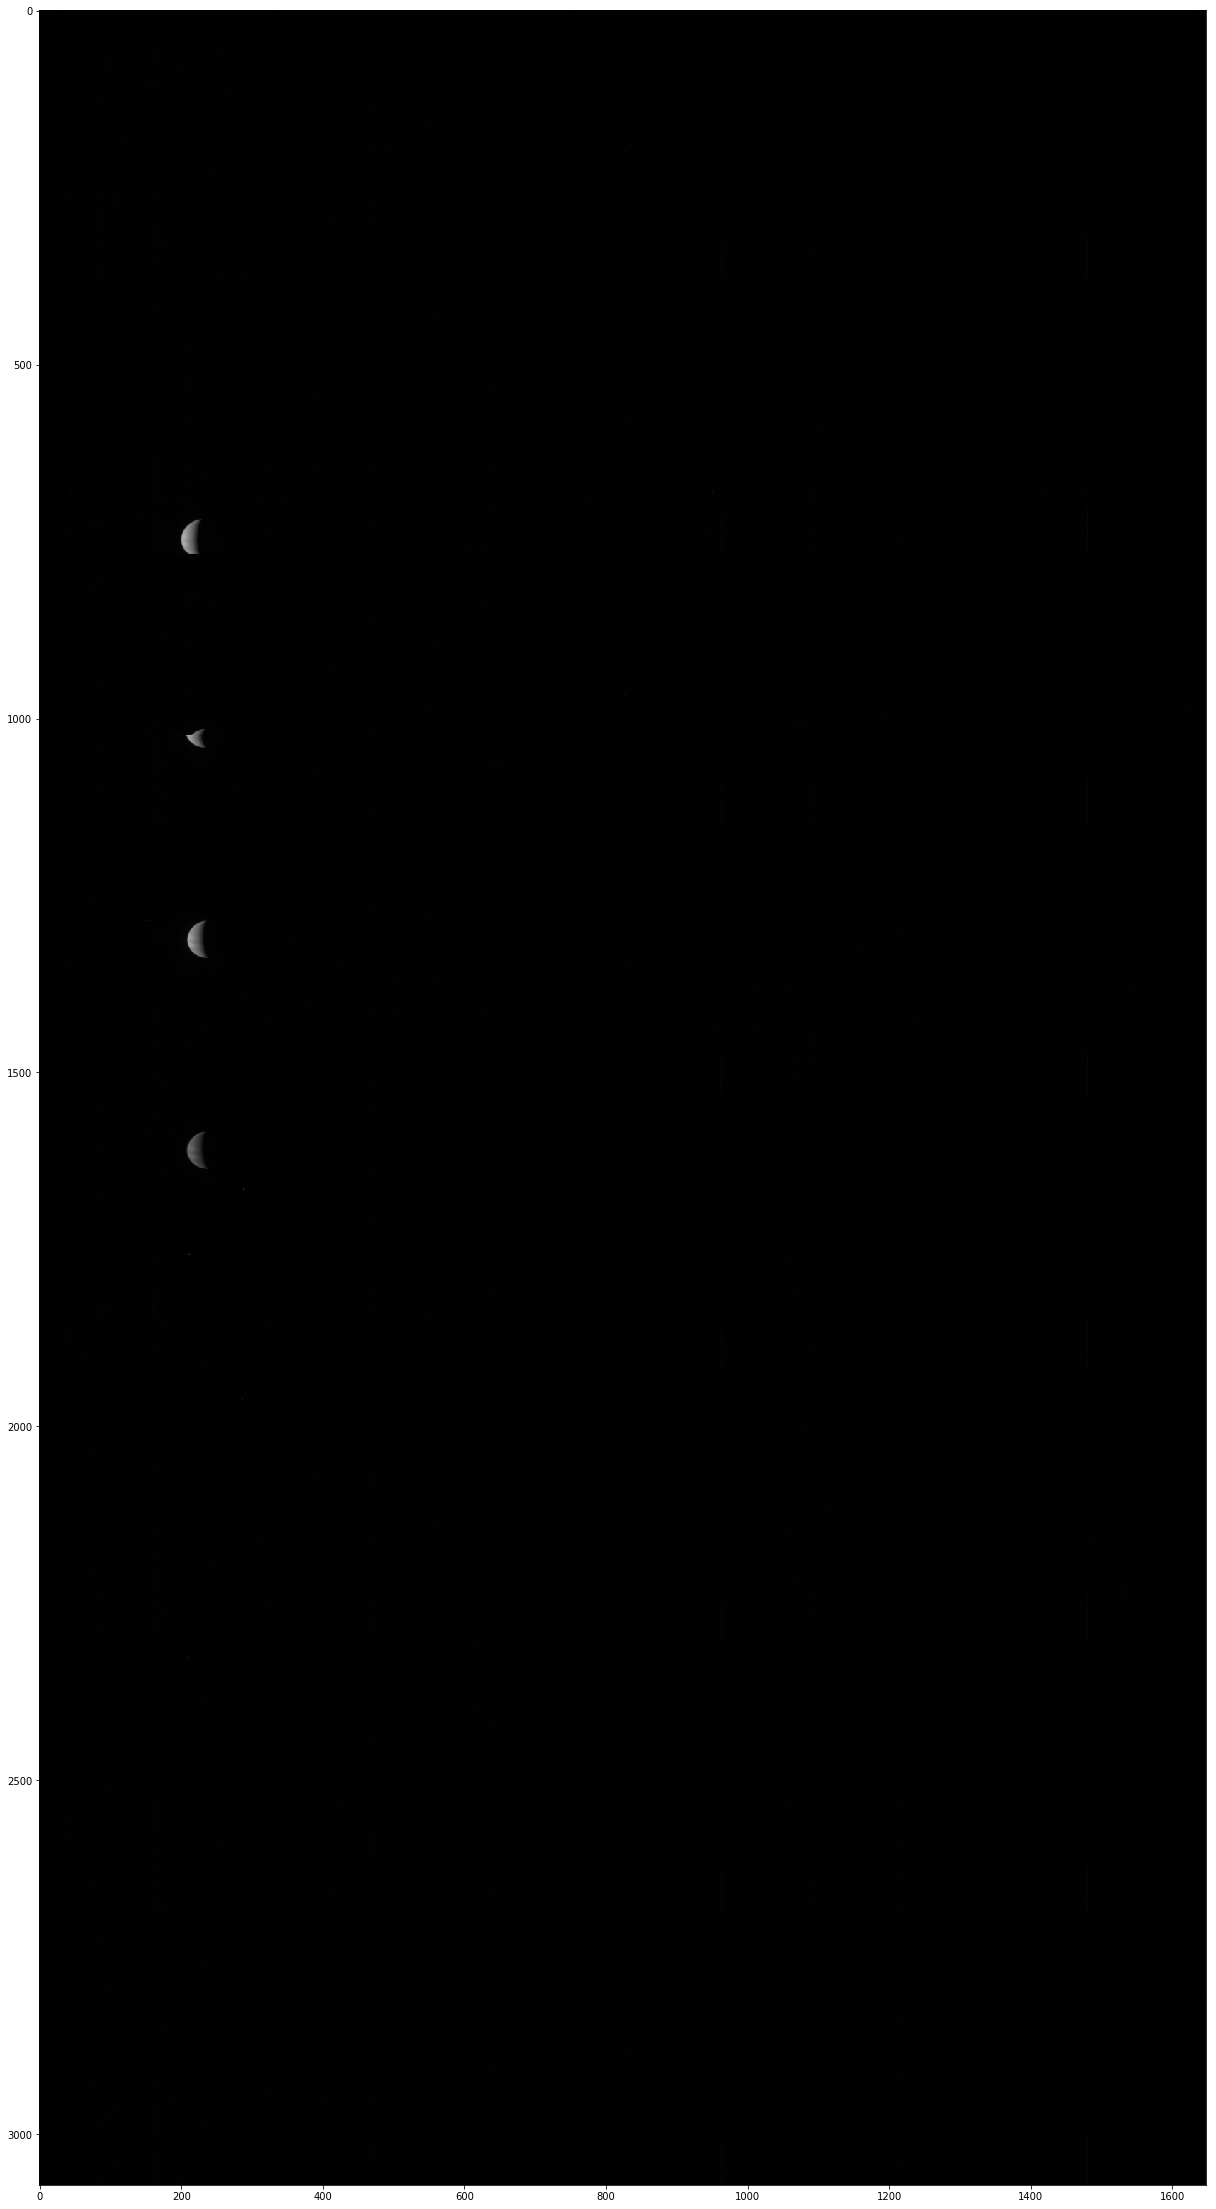

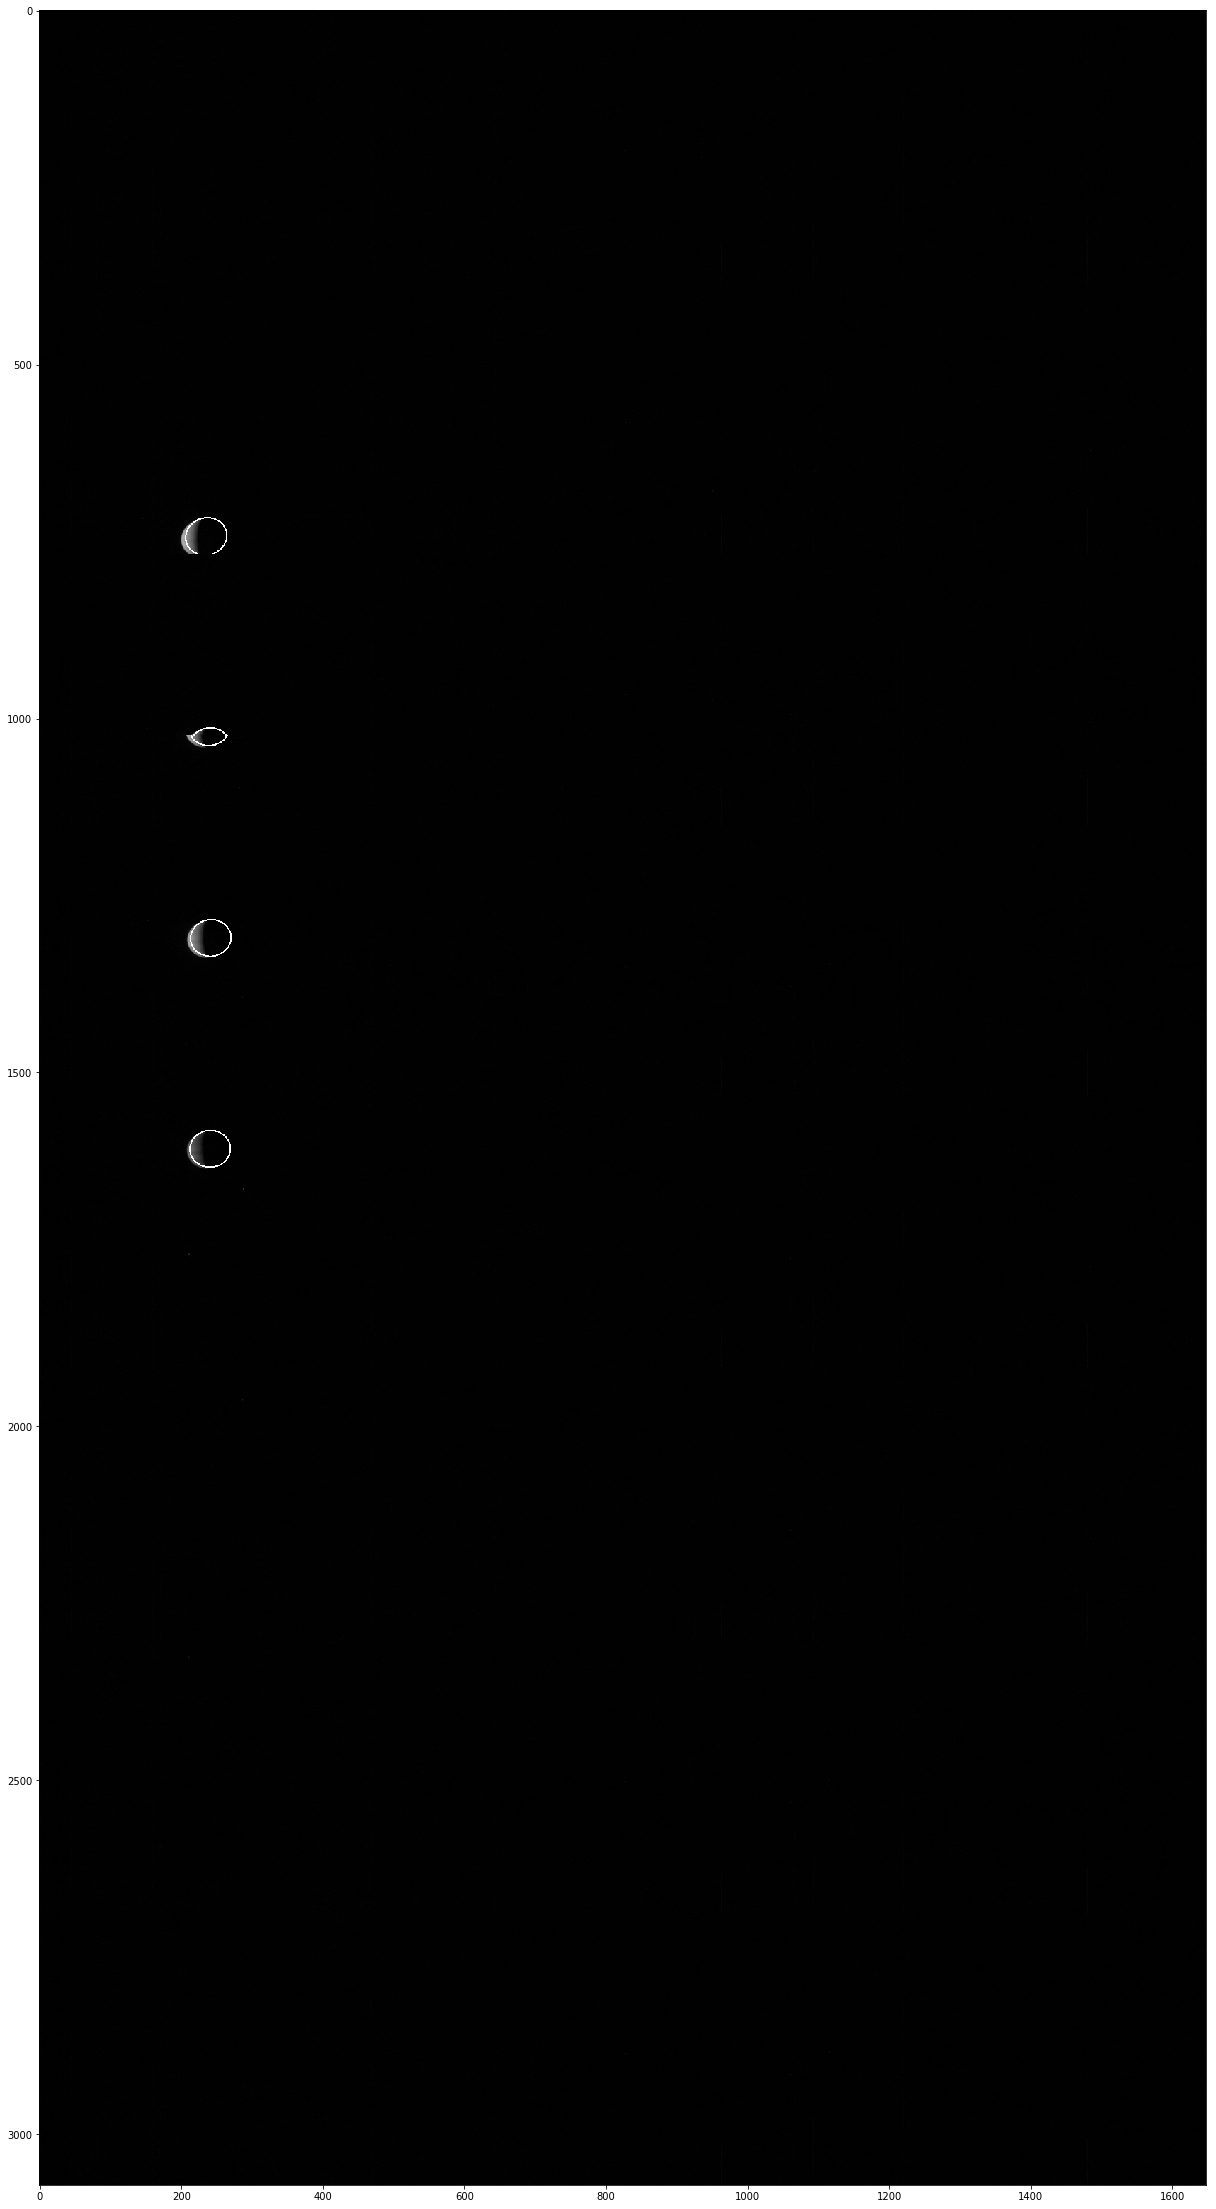

In [16]:
path = "testdata/"
jc.getkerns(path)
jc.readimage(path+"JNCE_2017038_04C00586_V01.LBL")
jc.im.mean()
jc.drawimage()
jc.find(0,1,"blue")
jc.find(128, 2, "green")
jc.find(256, 3, "red")
jc.drawimage()